Q table
[[ 7.29670868  1.80458448]
 [-0.23500732  2.33930175]
 [ 0.71900674  3.62966393]
 [ 0.20883563  3.25686649]]
Accumulated Reward
259.0


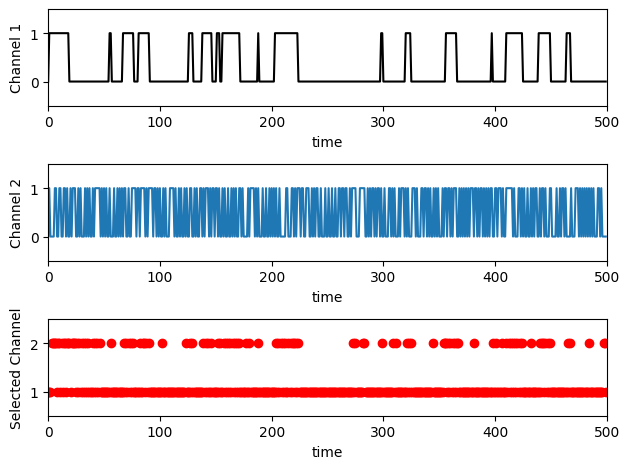

Final Accumulated Reward: 259.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def channel_state_generation(pbusy, pempty, time_horizon):
    """
    Generates the state of a channel over a given time horizon.

    Args:
        pbusy (float): Probability of transitioning from empty to busy.
        pempty (float): Probability of transitioning from busy to empty.
        time_horizon (int): The total number of time steps.

    Returns:
        numpy.ndarray: A 1D array representing the channel state (0 for empty, 1 for busy) over time.
    """
    chs = np.zeros(time_horizon)
    chs[0] = np.round(np.random.rand())

    for t in range(1, time_horizon):
        if chs[t-1] == 1:  # State Busy
            if np.random.rand() < pempty:
                chs[t] = 0
            else:
                chs[t] = 1
        else:  # State Empty
            if np.random.rand() < pbusy:
                chs[t] = 1
            else:
                chs[t] = 0
    return chs

def channel_selection_q_learning_case2(alfa, gamma):
    """
    Implements Q-learning for channel selection.

    Args:
        alfa (float): Learning rate.
        gamma (float): Discount factor.

    Returns:
        float: The accumulated reward over the time horizon.
    """
    seed = 2
    np.random.seed(seed)

    time_horizon = 500

    # Channel 1
    pbusy1 = 0.05
    pempty1 = 0.1
    chs1 = channel_state_generation(pbusy1, pempty1, time_horizon)

    # Channel 2
    pbusy2 = 0.6
    pempty2 = 0.6
    chs2 = channel_state_generation(pbusy2, pempty2, time_horizon)

    # ----- Q-learning -----

    # States = {Ch1E,Ch1B,Ch2E,Ch2B}={0,1,2,3} (adjusting to 0-based indexing)
    # Actions = {Stay,Change}={0,1} (adjusting to 0-based indexing)

    # We also need to explore to learn
    epsilon = 0.1
    delta = 0

    q_table = np.zeros((4, 2))  # The Q-table

    state = np.zeros(time_horizon, dtype=int)
    action = np.zeros(time_horizon, dtype=int)
    reward = np.zeros(time_horizon)
    channel = np.zeros(time_horizon, dtype=int)
    explore = np.zeros(time_horizon)

    k = 2  # Number of actions

    action_ntimes = np.zeros((4, 2))  # Times I selected one action

    state[0] = 0 + chs1[0]  # The agent starts in state 0 (Channel 1 Empty or Busy)
    channel[0] = 1

    # Rewards
    reward_good = 1
    reward_bad = -1
    ac_reward = 0

    for t in range(time_horizon - 1):

        if np.random.rand() < epsilon:
            p = np.random.randint(k)  # I explore an action randomly
            explore[t] = 1
        else:
            p = np.argmax(q_table[state[t], :])  # I take the best action from the current state

        action[t] = p
        action_ntimes[state[t], action[t]] += 1

        # Next State

        if state[t] == 0:  # Channel 1 Empty
            if action[t] == 0:  # stay
                state[t+1] = 0 + chs1[t+1]
                channel[t+1] = 1
            else:  # change
                state[t+1] = 2 + chs2[t+1]
                channel[t+1] = 2
        elif state[t] == 1:  # Channel 1 Busy
            if action[t] == 0:  # stay
                state[t+1] = 0 + chs1[t+1]
                channel[t+1] = 1
            else:  # change
                state[t+1] = 2 + chs2[t+1]
                channel[t+1] = 2
        elif state[t] == 2:  # Channel 2 Empty
            if action[t] == 0:  # stay
                state[t+1] = 2 + chs2[t+1]
                channel[t+1] = 2
            else:  # change
                state[t+1] = 0 + chs1[t+1]
                channel[t+1] = 1
        elif state[t] == 3:  # Channel 2 Busy
            if action[t] == 0:  # stay
                state[t+1] = 2 + chs2[t+1]
                channel[t+1] = 2
            else:  # change
                state[t+1] = 0 + chs1[t+1]
                channel[t+1] = 1

        # Reward

        if state[t+1] == 0 or state[t+1] == 2:  # Empty channel
            reward[t] = reward_good
        elif state[t+1] == 1 or state[t+1] == 3:  # Busy channel
            reward[t] = reward_bad

        ac_reward += reward[t]

        # Update Q-Table

        q_table[state[t], action[t]] = (1 - alfa) * q_table[state[t], action[t]] + alfa * (reward[t] + gamma * np.max(q_table[state[t+1], :]))

        # print('t state(t) action(t) reward(t) channel(t+1) state(t+1) Q_table(state(t),action(t)')
        # print([t, state[t], action[t], reward[t], channel[t+1], state[t+1], q_table[state[t],action[t]]])
        #
        # print('-----Q-table-----')
        # print(q_table)
        # print('-----------------')

        epsilon = max(0, epsilon - delta) # Ensure epsilon doesn't go below 0

    print('Q table')
    print(q_table)

    print('Accumulated Reward')
    print(ac_reward)

    plt.figure()
    plt.subplot(3, 1, 1)
    plt.plot(chs1, 'k')
    plt.axis([0, time_horizon, -0.5, 1.5])
    plt.xlabel('time')
    plt.ylabel('Channel 1')

    plt.subplot(3, 1, 2)
    plt.plot(chs2)
    plt.axis([0, time_horizon, -0.5, 1.5])
    plt.xlabel('time')
    plt.ylabel('Channel 2')

    plt.subplot(3, 1, 3)
    plt.plot(channel, 'ro')
    plt.axis([0, time_horizon, 0.5, 2.5])
    plt.xlabel('time')
    plt.ylabel('Selected Channel')
    plt.tight_layout()
    plt.show()

    return ac_reward

if __name__ == "__main__":
    alpha = 0.1
    gamma = 0.9
    accumulated_reward = channel_selection_q_learning_case2(alpha, gamma)
    print(f"Final Accumulated Reward: {accumulated_reward}")